<a href="https://colab.research.google.com/github/nilakshi104/Semantic_Segmentation-with-Camvid/blob/master/semantic_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install segmentation-models-pytorch

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=dc24e5d1cdf131f1468fc0429d6db56997ba5e69eca90ec5109d2f71465095e9
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=5735156365686e9129f6a12cfa1365cb745a35363bfdfe304c3b01d569c227d7
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [0]:
import cv2
from google.colab.patches import cv2_imshow
import torch
from torch.utils import data
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import os
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [0]:
dataroot = '/content/drive/My Drive/Untitled folder/Camvid dataset/'
ckptroot = '/content/drive/My Drive/Untitled folder/Camvid dataset/checkpoint_val'

In [0]:
np.random.seed(2)

(720, 960, 3)
(720, 960, 3)


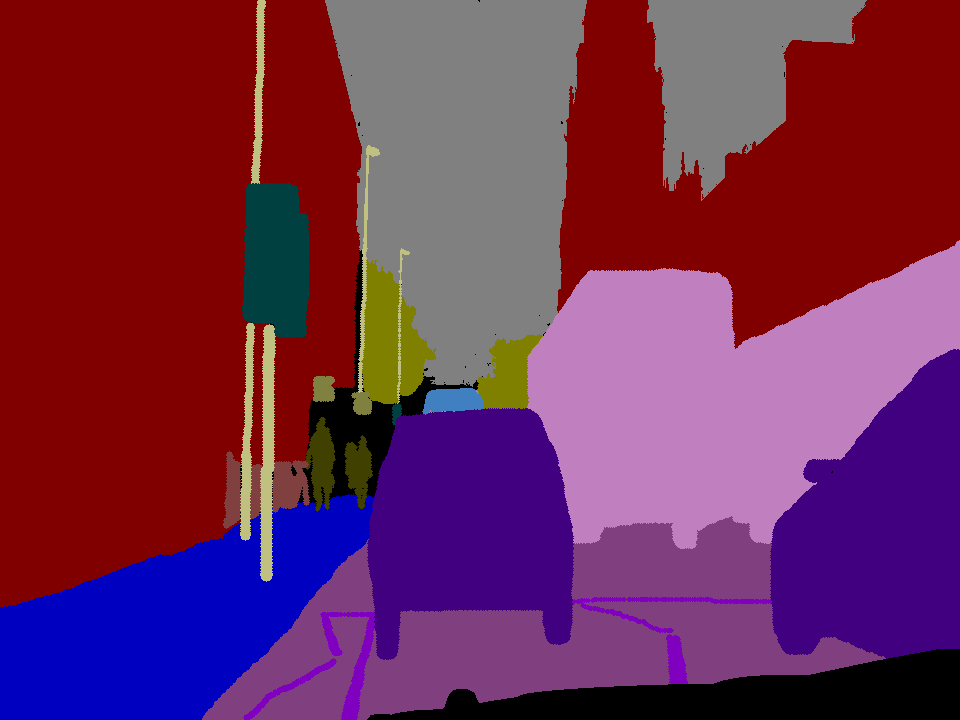

In [6]:
k=cv2.imread('/content/drive/My Drive/Untitled folder/Camvid dataset/train/0001TP_006690.png')
print(k.shape)
k_l=cv2.imread('/content/drive/My Drive/Untitled folder/Camvid dataset/train_labels/0001TP_006690_L.png')
print(k_l.shape)
cv2_imshow(k_l)

In [0]:
def load_img(folder):
    images = [];
    for filename in os.listdir(folder): # List all the filenames in the folder
        img = cv2.imread(os.path.join(folder, filename)); # Join the link of the folder and filename
        img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA);
        images.append(img);
    return images

# To load labeled gray-scaled images

def load_label_img(folder):
    images = [];
    for filename in os.listdir(folder): # List all the filenames in the folder
        img = cv2.imread(os.path.join(folder, filename)); # Join the link of the folder and filename
        img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
        images.append(img);
    return images

In [8]:
labels_name= np.loadtxt(dataroot+'labels1.txt',delimiter='\n',dtype=str);
labels_name

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'TunnelVegetation',
       'Misc', 'Void', 'Wall'], dtype='<U17')

In [0]:
colors=[]
def c2g(cn):
    cn = np.reshape(cn, (1, 1, 3));
    cn = cv2.cvtColor(cn, cv2.COLOR_BGR2GRAY);
    return cn;
colors.append(c2g(np.array([64, 128, 64], dtype = 'uint8')));# opencv supports uint8 and not int32/int64
colors.append(c2g(np.array([128, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 64], dtype = 'uint8')));

# c0 = np.reshape(np.array([64, 128, 0], dtype = 'uint8'), (1, 1, 3)); 
# c0 = cv2.cvtColor(c0, cv2.COLOR_BGR2GRAY)
# print(c0)

def class_pixel(label_img):
    class_pix = np.ones([256,256, 1], dtype = int);
    for index, c in enumerate(colors):
        class_pix[label_img == c] = index; # Vectorized masking is much much faster
    return class_pix


def label_img_list(img_list):
    images = [];
    for image in img_list:
        images.append(class_pixel(image));
    return images;


In [0]:
transform_img = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.409, 0.4, 0.38],   # input[channel] = (input[channel] - mean[channel]) / std[channel]
                        std=[0.27, 0.27, 0.26])])

transform_img_label = transforms.Compose([
    transforms.ToTensor()
])
# We have to create custom classes in order to use the DataLoader. These classes inherit the Dataset class

class trainset(data.Dataset):
    def __init__(self, transform = None, root_train = None, root_train_label = None, transform_label = None):
        self.train_img = load_img(root_train);
        self.transform = transform;
        self.transform_label = transform_label;
        self.train_label_img = label_img_list(load_label_img(root_train_label));
        
    def __len__(self):
        return len(self.train_img);
    
    def __getitem__(self, index):
      
        img = self.transform(self.train_img[index]);
        label = self.transform_label(self.train_label_img[index]);
        return img, label;

class valset(data.Dataset):
    def __init__(self, transform = None, root_val = None, root_val_label = None, transform_label = None):
        self.val_img = load_img(root_val);
        self.transform = transform;
        self.transform_label = transform_label;
        self.val_label_img = label_img_list(load_label_img(root_val_label));
        
    def __len__(self):
        return len(self.val_img);
    
    def __getitem__(self, index):
        img = self.transform(self.val_img[index]);
        label = self.transform_label(self.val_label_img[index]);
        return img, label

    
class testset(data.Dataset):
    def __init__(self, transform = None, root_test = None, root_test_label = None, transform_label = None):
        self.test_img = load_img(root_test);
        self.transform = transform;
        self.transform_label = transform_label;
        self.test_label_img = label_img_list(load_label_img(root_test_label));
        
    def __len__(self):
        return len(self.test_img);
    
    def __getitem__(self, index):
        img = self.transform(self.test_img[index]);
        label = self.transform_label(self.test_label_img[index]);
        return img, label


traindataset = trainset(transform_img,dataroot+'train/',dataroot+'train_labels/' , transform_img_label);
testdataset = testset(transform_img,dataroot+'test/',dataroot+'test_labels/' , transform_img_label);
valdataset = valset(transform_img,dataroot+'val/',dataroot+'val_labels/' , transform_img_label);

In [0]:
batch_size=2
num_workers=1
train_loader = data.DataLoader(traindataset,batch_size= batch_size , shuffle=True,  num_workers=num_workers);
test_loader = data.DataLoader(testdataset,batch_size= batch_size , shuffle=True,  num_workers=num_workers);
val_loader = data.DataLoader(valdataset ,batch_size= batch_size , shuffle=True,  num_workers=num_workers);

In [12]:
# import segmentation_models as sm

# ENCODER = 'resnet34'
# ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'TunnelVegetation',
       'Misc', 'Void', 'Wall']
# ACTIVATION = None # could be None for logits or 'softmax2d' for multicalss segmentation
# DEVICE = 'cuda'

# # create segmentation model with pretrained encoder
# model = smp.FPN(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )

BACKBONE='resnet34'
n_classes=len(CLASSES)
activation=None
model = smp.Unet(BACKBONE, classes=n_classes, activation=activation)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [13]:
n_classes

32

In [14]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [21]:
epochs=20
start_epoch=0
lr=1e-3
wd=1e-7
optimizer = optim.Adam(model.parameters(),
                       lr=lr,
                       weight_decay=wd,
                       betas = (0.9, 0.99),
                       eps = 1e-7)
criterion = nn.CrossEntropyLoss();
scheduler = MultiStepLR(optimizer, milestones=[30, 50], gamma=1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
def toDevice(datas, device):
    # Enable cuda
    imgs, labels = datas
    return imgs.to(device), labels.to(device)

cuda:0


In [0]:
class Trainer(object):
  'Trainer'
  def __init__(self,
               ckptroot,
               model,
               devices,
               epochs,
               criterion,
               optimizer,
               scheduler,
               start_epoch,
               train_loader,
               val_loader
               ):
      super(Trainer,self).__init__()

      self.model=model
      self.device=device
      self.epochs=epochs
      self.ckptroot=ckptroot
      self.criterion=criterion
      self.optimizer=optimizer
      self.scheduler=scheduler
      self.start_epoch=start_epoch
      self.train_loader=train_loader
      self.val_loader=val_loader

  def train(self):
      # trainloss=[]
      # valloss=[]
      trainloss1=[]
      valloss1=[]
      # self.model.to(self.device)
      for epoch in range(self.start_epoch,self.epochs+self.start_epoch):
        print(epoch)
        train_loss=0
        self.model.train()
        for local_batch,train_img  in enumerate(self.train_loader):
          # train_img=toDevice(train_img,self.device)
          self.optimizer.zero_grad()
          imgs,labels=train_img
          output=self.model(imgs)
          outpt=output.type(torch.LongTensor)
          loss=self.criterion(output,labels.squeeze(1))
          loss.backward()
          self.optimizer.step()
          train_loss +=loss
        
          # if local_batch % 25 ==0:
          #   print(f"Training Epoch: {epoch} | Loss: {loss} | Training_Loss: {train_loss/(local_batch+1)}")

        # trainloss.append(train_loss/(local_batch+1))
        trainloss1.append(train_loss)

        self.scheduler.step()
        self.model.eval()
        valid_loss=0
        with torch.set_grad_enabled(False):
          for local_batch,val_img in enumerate(self.val_loader):
              # val_img=toDevice(val_img,self.device)
              self.optimizer.zero_grad()
              imgs,labels=val_img
              output=self.model(imgs)
              outpt=output.type(torch.LongTensor)
              loss=self.criterion(output,labels.squeeze(1))
              valid_loss += loss
              # if local_batch % 25 ==0:
                # print(f"Val Epoch: {epoch} | Loss: {valid_loss / (local_batch + 1)}")

          # valloss.append(valid_loss/(local_batch+1))
          valloss1.append(valid_loss)
          
          # Save model
        if epoch>98:
            state = {
                'epoch': epoch + 1,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'input_size':3,
                'output_size':1,
                # 'hidden_layers':[each.out_features for each in model.hidden_layers],
                'loss':loss
            }
            self.save_checkpoint(state)
            print("==> Save checkpoint ...")

      plt.subplot(2,1,1)
      plt.plot(trainloss1)
      plt.subplot(2,1,2)
      plt.plot(valloss1)


  def save_checkpoint(self, state):
    """Save checkpoint."""
    print("==> Save checkpoint ...")
    if not os.path.exists(self.ckptroot):
        os.makedirs(self.ckptroot)

    torch.save(state, self.ckptroot + 'segmentation model:-{}.h5'.format(state['epoch']))
           

==> Start training ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


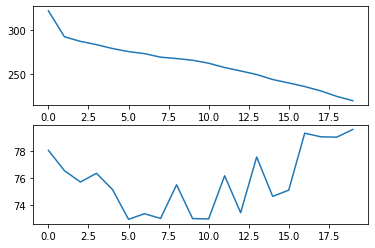

In [23]:
print("==> Start training ...")
trainer = Trainer(ckptroot,
                  model,
                  device,
                  epochs,
                  criterion,
                  optimizer,
                  scheduler,
                  start_epoch,
                  train_loader,
                  val_loader)
trainer.train()

In [48]:
name2id = {v:k for k,v in enumerate(labels_name)}
void_code=name2id['Void']

def corr(x): # To get proper correspondence between the outputs and the labels
    # x = x.cpu();
    x = x.detach().numpy(); # Detach() was used as one can't convert a pytorch tensor to a numpy array if required_grad is set True for that variable
    x = x.argmax(axis = 1);
    return x;

# Compute test-set accuracy

correct = 0;
total = 0;
for i, data in enumerate(test_loader):
    inputs, labels = data;
    # inputs = inputs
    outputs = model(inputs);
    outputs = corr(outputs);
    labels = labels.detach().numpy();
    # outputs = outputs.squeeze(1)
    outputs=np.squeeze(outputs)
    # labels=labels.squeeze(1)
    labels=np.squeeze(labels)
    for i in range(256):
      for j in range(256):
          total = total + 1;
          if labels.any() != void_code:
            if (outputs[1, i, j] == labels[1, i, j]):
              correct = correct + 1;
          else:
            correct=correct+1
            print('void')

print("Hence, the test set accuracy is ", (correct/total) * 100);

Hence, the test set accuracy is  58.060437157040546


In [51]:
colors_rev = [];
colors_rev.append(np.array([64, 128, 64], dtype = 'uint8'));
colors_rev.append(np.array([128, 0, 192], dtype = 'uint8'));
colors_rev.append(np.array([192, 128, 0], dtype = 'uint8'));
colors_rev.append(np.array([64, 128, 0], dtype = 'uint8'));
colors_rev.append(np.array([0, 0, 128], dtype = 'uint8'));
colors_rev.append(np.array([128, 0, 64], dtype = 'uint8'));
colors_rev.append(np.array([192, 0, 64], dtype = 'uint8'));
colors_rev.append(np.array([64, 128, 192], dtype = 'uint8'));
colors_rev.append(np.array([128, 192, 192], dtype = 'uint8'));
colors_rev.append(np.array([128, 64, 64], dtype = 'uint8'));
colors_rev.append(np.array([192, 0, 128], dtype = 'uint8'));
colors_rev.append(np.array([64, 0, 192], dtype = 'uint8'));
colors_rev.append(np.array([64, 128, 128], dtype = 'uint8'));
colors_rev.append(np.array([192, 0, 192], dtype = 'uint8'));
colors_rev.append(np.array([64, 64, 128], dtype = 'uint8'));
colors_rev.append(np.array([128, 192, 64], dtype = 'uint8'));
colors_rev.append(np.array([0, 64, 64], dtype = 'uint8'));
colors_rev.append(np.array([128, 64, 128], dtype = 'uint8'));
colors_rev.append(np.array([192, 128, 128], dtype = 'uint8'));
colors_rev.append(np.array([192, 0, 0], dtype = 'uint8'));
colors_rev.append(np.array([128, 128, 192], dtype = 'uint8'));
colors_rev.append(np.array([128, 128, 128], dtype = 'uint8'));
colors_rev.append(np.array([192, 128, 64], dtype = 'uint8'));
colors_rev.append(np.array([64, 0, 0], dtype = 'uint8'));
colors_rev.append(np.array([64, 64, 0], dtype = 'uint8'));
colors_rev.append(np.array([128, 64, 192], dtype = 'uint8'));
colors_rev.append(np.array([0, 128, 128], dtype = 'uint8'));
colors_rev.append(np.array([192, 128, 192], dtype = 'uint8'));
colors_rev.append(np.array([64, 0, 64], dtype = 'uint8'));
colors_rev.append(np.array([0, 192, 192], dtype = 'uint8'));
colors_rev.append(np.array([0, 0, 0], dtype = 'uint8'))
colors_rev.append(np.array([0, 192, 64], dtype = 'uint8'));

def test(op_img):
    class_pix = np.ones([256,256, 3], dtype = 'uint8');
    for index, c in enumerate(colors_rev):
        class_pix[op_img == index] = c; # Vectorized masking is much much faster
    # return class_pix.reshape((85,85, 3))
    return class_pix

print(labels[0])
print(outputs[0])

[[ 4  4  4 ... 26 26 26]
 [ 4  4  4 ... 26 26 26]
 [ 4  4  4 ... 26 26 26]
 ...
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]]
[[ 4  4  4 ... 21 21 26]
 [ 4  4  4 ... 26 26 26]
 [ 4  4  4 ... 26 26 26]
 ...
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]]


<class 'numpy.ndarray'>
(256, 256, 3)


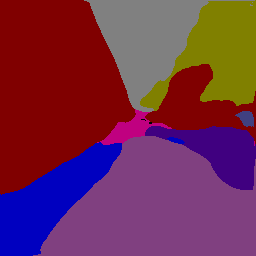

In [52]:
# outputs=outputs.detach().numpy()
print(type(test(outputs[0])));
a = test(outputs[0]);
a = a.reshape([256,256, 3])
print(a.shape)
from google.colab.patches import cv2_imshow
cv2_imshow(a)

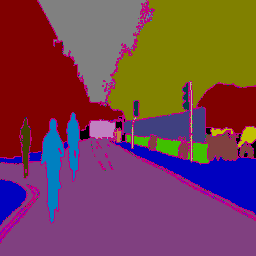

In [53]:
d=test(labels[0])
cv2_imshow(d)